In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
import commands

## Topology

(0.1, 0.9)

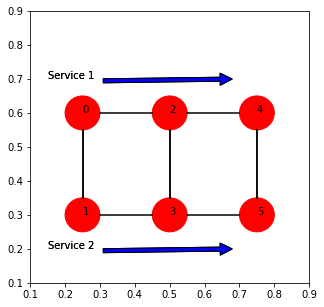

In [42]:
plt.figure(figsize=(5,5))
ax = plt.gca()
for i in xrange(2):
    for j in xrange(3):
        circle = plt.Circle((0.25*(j+1), 0.3*(i+1)), 0.05, color='r')
        ax.add_artist(circle)
        ax.annotate(str((1-i)+2*j), (0.25*(j+1), 0.3*(i+1)))
        plt.plot([0.25*(j+1), 0.25*(j+1)], [0.35, 0.55], color='k')
    plt.plot([0.3, 0.45], [0.3*(i+1), 0.3*(i+1)], color='k')
    plt.plot([0.55, 0.7], [0.3*(i+1), 0.3*(i+1)], color='k')
    ax.annotate('Service 1', xy=(0.7, 0.7), xytext=(0.15, 0.7), arrowprops=dict(facecolor='blue', shrink=0.05))
    ax.annotate('Service 2', xy=(0.7, 0.2), xytext=(0.15, 0.2), arrowprops=dict(facecolor='blue', shrink=0.05))
plt.xlim((0.1,0.9))
plt.ylim((0.1,0.9))

In [3]:
def test(N, t, deltar, policy, V):
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)

    commands.getstatusoutput(sim_command)    
    
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    cost = pd.DataFrame.from_csv(output_dir + 'cost_' + sim_instance + '.csv')
    
    node_rate_columns = schedule.columns[[('rate' in x and 'node' in x) for x in schedule.columns]]
    link_rate_columns = schedule.columns[[('rate' in x and 'link' in x) for x in schedule.columns]]

    #plt.figure()
    #schedule[node_rate_columns].head(1000).plot()
    
    plt.figure()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5));
    schedule[node_rate_columns].mean().plot(kind='bar', ax=axes[0])
    plt.title('V = ' + str(V))
    
    schedule[link_rate_columns].mean().plot(kind='bar', ax=axes[1])
    
    queue.sum(axis=1).plot(ax=axes[2])
    
    print 'Mean queue length sum = ', queue.sum(axis=1).mean()
    print 'Mean cost = ', cost.sum(axis=1).mean()
    #print queue.mean()
    return schedule, queue, cost

## Adaptive DCNC with various parameter V

For each V, the subfigures indicate 

(a) mean process rate at each node (b) mean transmission rate at each link (c) evoluation of total queue length

In [4]:
N = 6
t = 100000
deltar = 10
V = 10.0
policy = 'ADCNC'

V =  1.0
Mean queue length sum =  6059.84562
Mean cost =  219.01561
V =  5.0
Mean queue length sum =  6722.89345
Mean cost =  177.28379
V =  10.0
Mean queue length sum =  7605.25661
Mean cost =  148.71698
V =  50.0
Mean queue length sum =  17234.13095
Mean cost =  102.55897
V =  100.0
Mean queue length sum =  24517.51541
Mean cost =  63.81742


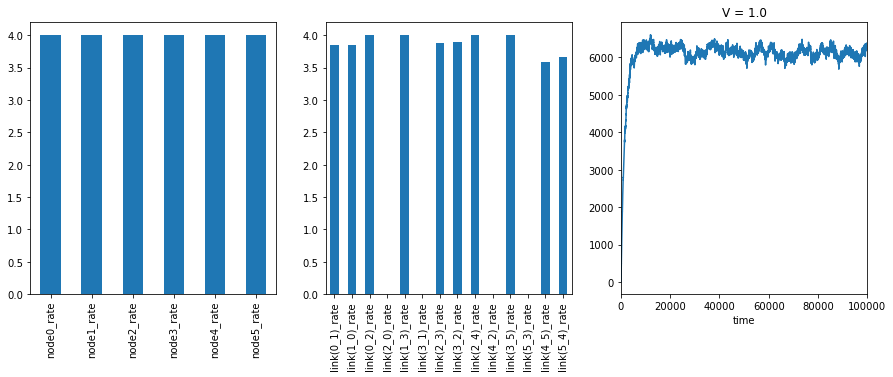

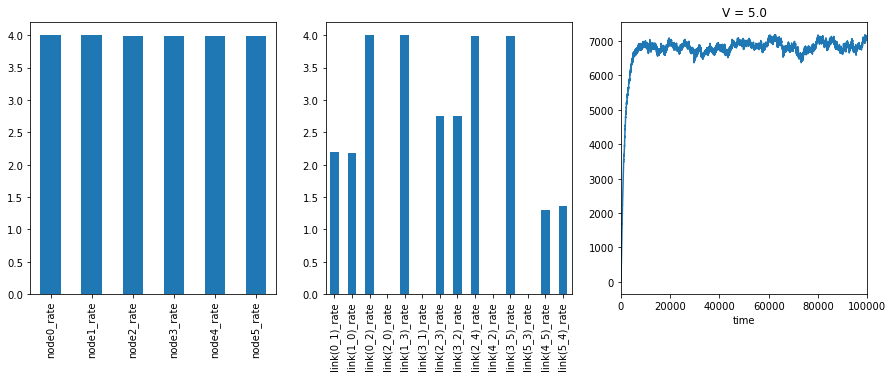

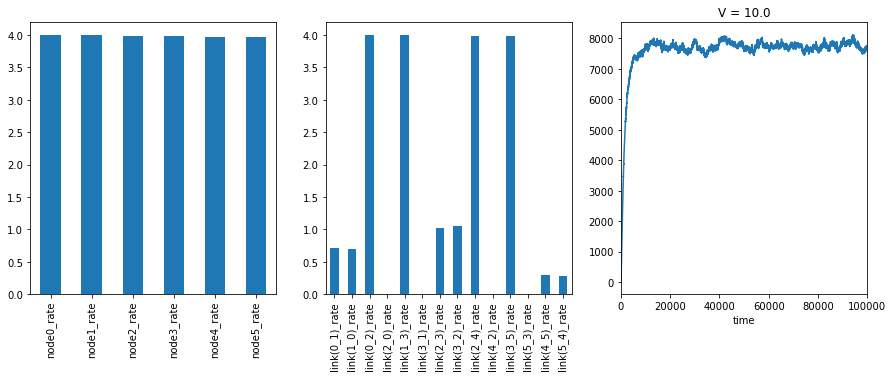

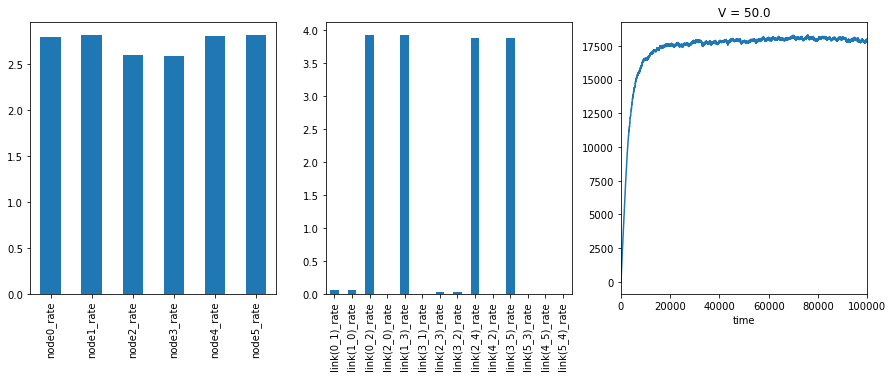

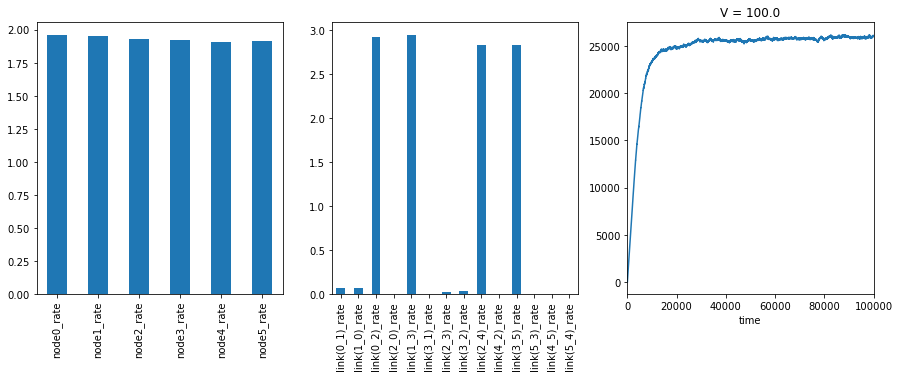

In [5]:
costs = []
queues = []
for V in [1.0, 5.0, 10.0, 50.0, 100.0]:
    print 'V = ', V
    schedule, queue, cost = test(N, t, deltar, policy, V)
    costs.append(cost.sum(axis=1).mean())
    queues.append(queue.sum(axis=1).mean())
    del schedule, queue, cost

#### Cost - Delay tradeoff with varying V

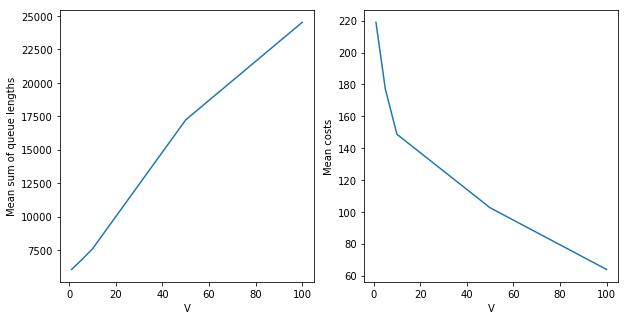

In [6]:
Vs = [1.0, 5.0, 10.0, 50.0, 100.0]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Vs, queues)
plt.xlabel('V')
plt.ylabel('Mean sum of queue lengths')
plt.subplot(1,2,2)
plt.plot(Vs, costs)
plt.xlabel('V')
plt.ylabel('Mean costs')

## Processing and transmission rate for each commodity

For each node/link, commodity 0 indicates the time portion that the node/link is in reconfiguration.

In [7]:
def rate_plot(schedule, V):
    rates = pd.DataFrame()
    for n in xrange(N):
        node = schedule.columns[['node'+str(n) in x for x in schedule.columns]]
        df = schedule[node].copy()
        df.loc[df['node'+str(n)+'_reconfig'] > 0, 'node'+str(n)+'_packet'] = None
        df = df.fillna(0)
        df = (df.groupby('node'+str(n)+'_packet').sum() / df.shape[0])[['node'+str(n)+'_rate']]
        df.index.name = ''
        if rates.empty:
            rates = df
        else:
            rates = rates.join(df, how='outer')

    rates = rates.sort_index(ascending=False)
    rates = rates.stack()
    rates = rates.unstack(0)
    
    link_rates = pd.DataFrame()
    for l in schedule.columns[['link' in x and 'rate' in x for x in schedule.columns]].str.strip('_rate'):
        link = schedule.columns[[l in x for x in schedule.columns]]
        df = schedule[link].copy()
        df.loc[df[l+'_reconfig'] > 0, l+'_packet'] = None
        df = df.fillna(0)
        df = (df.groupby(l+'_packet').sum() / df.shape[0])[[l+'_rate']]
        if link_rates.empty:
            link_rates = df
        else:
            link_rates = link_rates.join(df, how='outer')

    link_rates = link_rates.sort_index(ascending=False)
    link_rates = link_rates.stack()
    link_rates = link_rates.unstack(0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6));
    rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[0], colormap='nipy_spectral')
    axes[0].set_title('V = ' + str(V))
    link_rates.plot(kind='bar', stacked=True, ylim=[0,4], ax=axes[1], colormap='nipy_spectral')
    axes[1].set_title('V = ' + str(V))

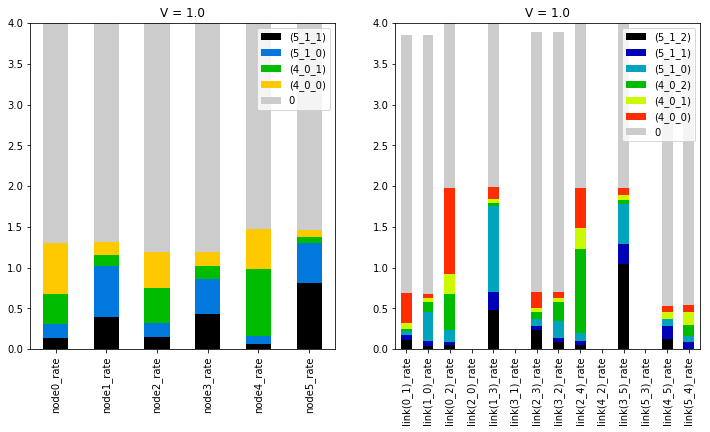

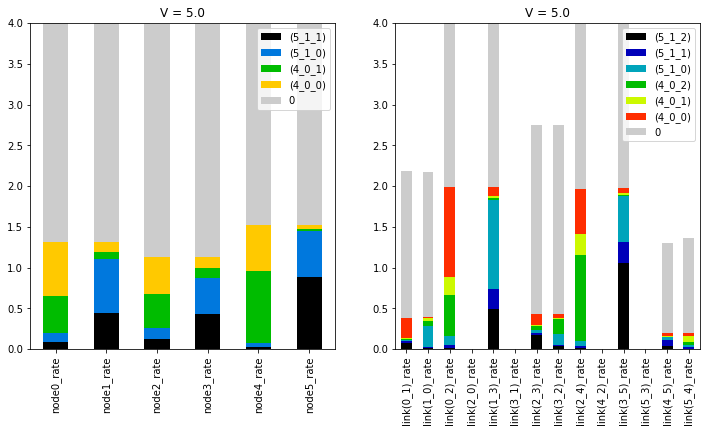

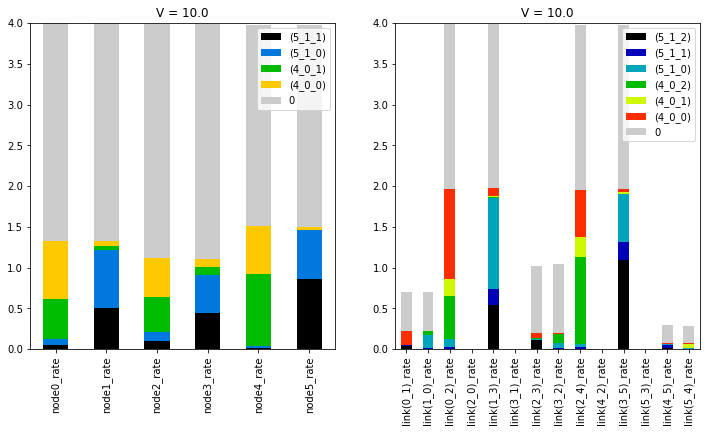

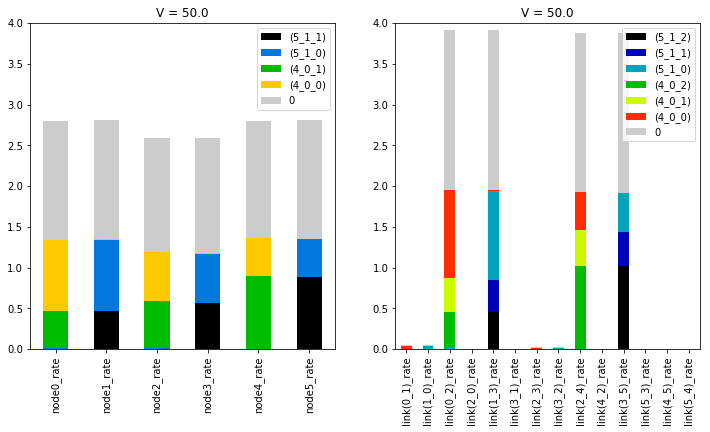

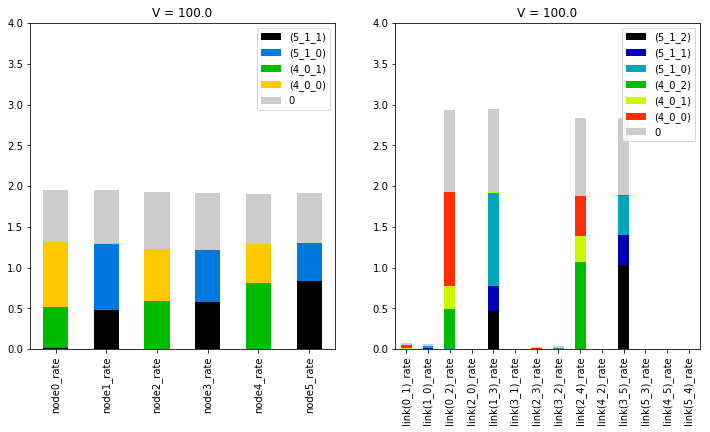

In [8]:
for V in Vs:
    output_dir = 'output/sim/'
    sim_command = './test t=' + str(t) + ' deltar=' + str(deltar) + ' policy=' + policy + ' V=' + str(V)
    sim_instance = 'N_' + str(N) + '_t_' + str(t) + '_deltar_' + str(deltar) + '_' + policy + '_V_' + str(V)
    schedule = pd.DataFrame.from_csv(output_dir + 'schedule_' + sim_instance + '.csv')
    #queue = pd.DataFrame.from_csv(output_dir + 'queue_' + sim_instance + '.csv')
    
    plt.figure()
    rate_plot(schedule, V)

In [9]:
N = 6
t = 100000
deltar = 10
policy = 'DCNC'
V = 1.0

Mean queue length sum =  200004.43458
Mean cost =  224.16564


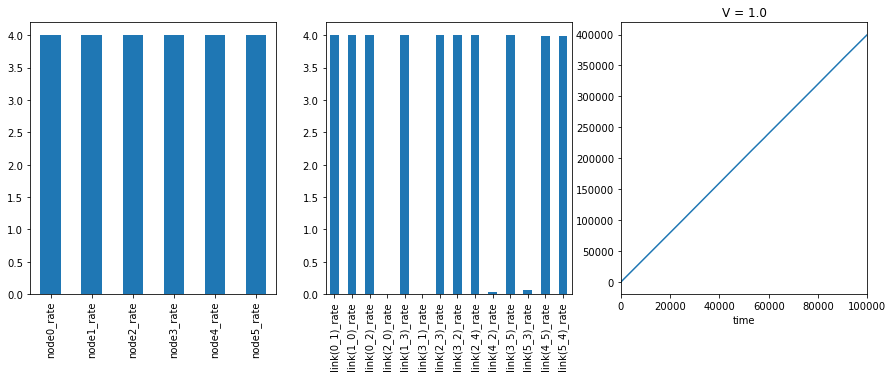

In [10]:
schedule, queue, cost = test(N, t, deltar, policy, V)